This goes through the general pipeline to analyze the ATP calibrations for ATEAM.

Here I am using AT1.03 full-field with motors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [3]:
import atp_cal

In [4]:
atp_cal.pboc_style_mpl()

# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

## Settings and Functions

#### Image Plotting Settings

In this cell I specify the size of images and the conversion of pixels to µm. As well as, some settings for plotting in holoviews

In [5]:
# Length calibration [microns per pixel]
um_per_pixel = 0.29

# Image dimensions
w_px, h_px = 1920, 1200
w_um, h_um = w_px*um_per_pixel, h_px*um_per_pixel

#bounds
bounds = [0, 0, w_um, h_um]

#Set the frame size of the image to enforce square pixels (holoviews does not have this preset)
frame_height = 200
frame_width = w_px * frame_height // h_px

#Preset these settings as opts
opts = dict(
    frame_height=frame_height,
    frame_width=frame_width,
    xlabel="µm",
    ylabel="µm",
    cmap = 'viridis'
)

#### Parameters:
Here list ATP concentration

## Import Images

In [17]:
int(np.sort(glob.glob('../../data/atp_cal/2023-11-06_ATeam_Cal/*Nikon*/*ATP*/*YFP*.tif'))[0].split('/')[6].split('uM')[0])

0

In [72]:
#This should not change between experiments:
datapath = '../../data/atp_cal'

#This varies between experiments. 
datafolder = '2023-11-06_ATeam_Cal/*Nikon*/*ATP*'

# YFP Images
included_YFP = '*YFP*.tif'
YFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))

# CFP Images
included_CFP = '*CFP*.tif'
CFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))

ATPconc=[]
for i, file in enumerate(CFP_files):
    conc = int(file.split('/')[6].split('uM')[0])
    ATPconc.append(conc)
ATPconc = np.array(ATPconc)

#Read in images and save as array:
YFP_array = atp_cal.file_to_image(YFP_files)
CFP_array = atp_cal.file_to_image(CFP_files)

# Set background - want a no ATeam image for this - going based on the 6/29/2022 data
YFP_bg = 1919
CFP_bg = 1917


# Define the zero concentration image (DO EVERY TIME):
YFP_zero = np.average(YFP_array[np.where(ATPconc==0)], axis=0)
CFP_zero = np.average(CFP_array[np.where(ATPconc==0)], axis=0)

# # ------------------------------------------------------------------------------ #

# #Import Background images
# bgfolder = '2022-06-29_ATeam_Cal/2022-06-29_ATeam_Cal_1/images'

# bgYFP_name = 'C1-2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome'
# bgCFP_name = 'C2-2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome'
# bgMot_name = 'C3-2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome'

# #2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome0000

# #YFP_bg = atp_cal.file_to_image(np.sort(glob.glob(datapath+'/'+bgfolder+'/'+bgYFP_name)))
# YFP_bg = skimage.io.imread(datapath+'/'+bgfolder+'/'+bgYFP_name+'.tif')
# CFP_bg = skimage.io.imread(datapath+'/'+bgfolder+'/'+bgCFP_name+'.tif')
# Mot_bg = skimage.io.imread(datapath+'/'+bgfolder+'/'+bgMot_name+'.tif')

# # Define an average offset
# YFP_bg_offset = np.average(YFP_bg)
# CFP_bg_offset = np.average(CFP_bg)
# Mot_bg_offset = np.average(Mot_bg)

## Subtract background

In [73]:
#Subtract im_dark from all calibration images
YFP_bs = YFP_array - YFP_bg
CFP_bs = CFP_array - CFP_bg

In [74]:
CFP_bs[CFP_bs<0] = 0
YFP_bs[CFP_bs<0] = 0

## Correct for uneven illumination background subtraction

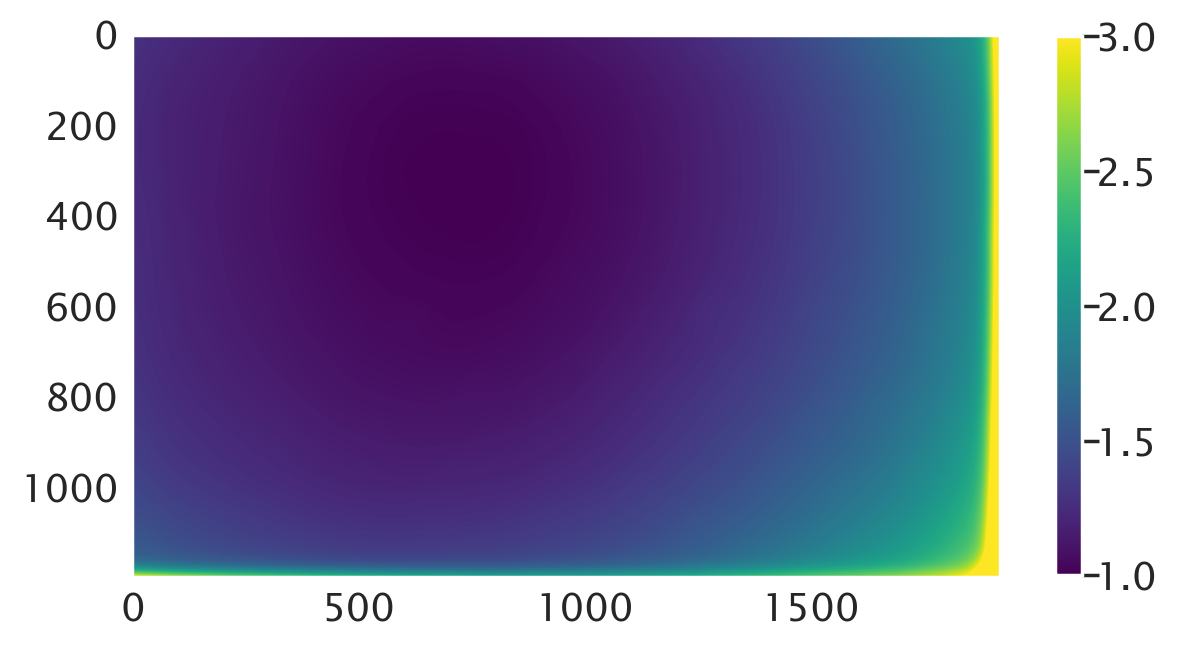

In [75]:
#Find the normilization matrix
YFP_norm_mat = atp_cal.norm_mat_fn_iATP(YFP_zero, YFP_bg)
CFP_norm_mat = atp_cal.norm_mat_fn_iATP(CFP_zero, CFP_bg)

#plot the normalizaiton matrix
plt.imshow(CFP_norm_mat, vmin = 1, vmax = 3)
plt.colorbar(shrink = 0.7)
plt.grid(False)

In [76]:
#Normalize all the claibration images by multiplying by the normalization matrix
YFP_norm = YFP_bs*YFP_norm_mat
CFP_norm = CFP_bs*CFP_norm_mat

## Calculate the average intensity value per concentration

In [77]:
#Average over the non-zero values in the image to get the calibration
YFP_calavg = np.average(YFP_norm, axis=(1,2))
CFP_calavg = np.average(CFP_norm, axis=(1,2))
ratio_calavg = YFP_calavg/CFP_calavg 

## Plot the data and fit to a Hill function

In [78]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)**2/(1+(conc/a)**2))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2])
    
    return param, curve, xvals

[48.67753051  2.99787587  0.97143844]


Text(0.5, 1.0, 'ATP Calibration Curve, Km = 49 µM')

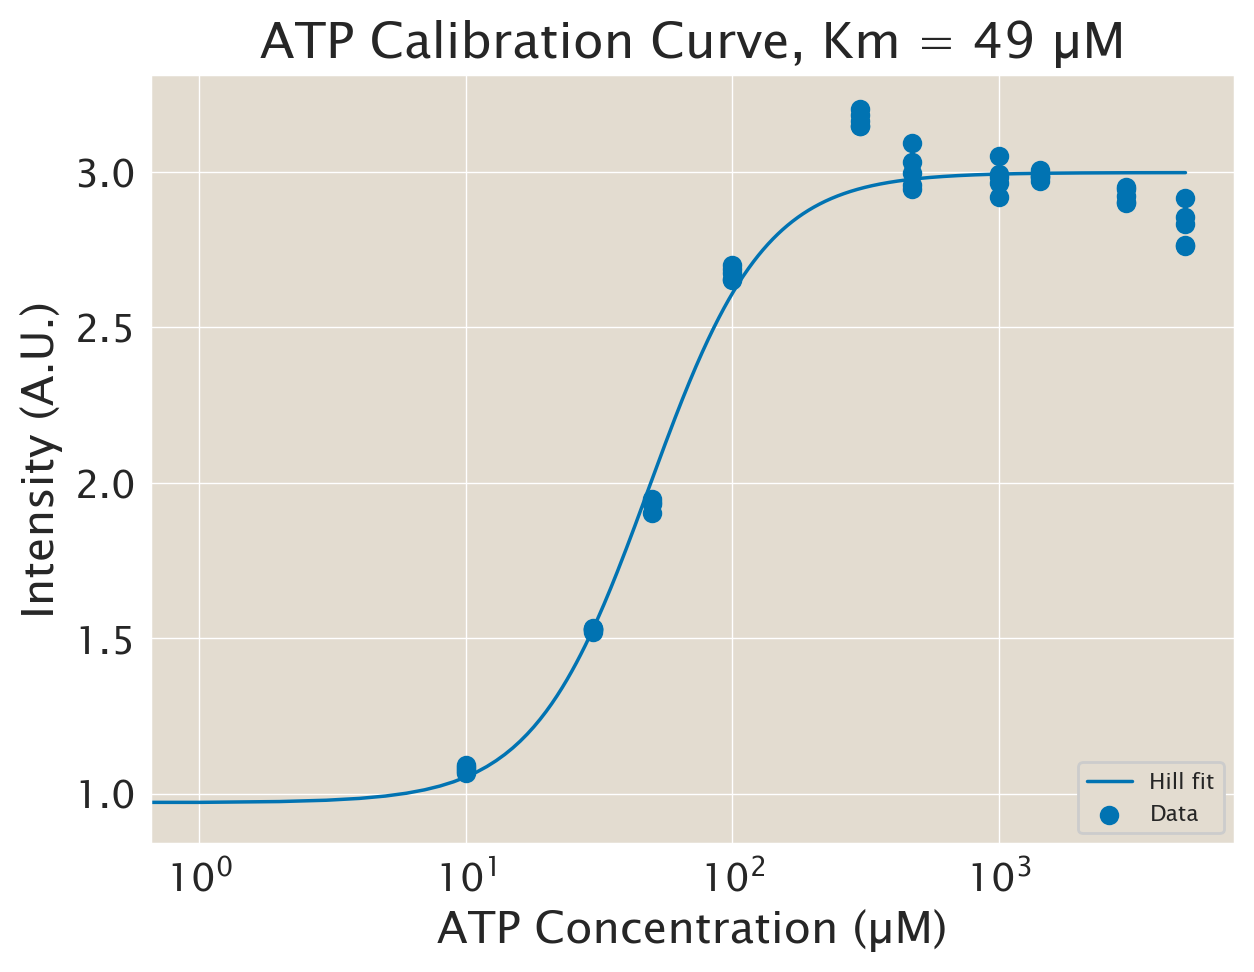

In [83]:
params, curve, xvals = ATeam_Hill_curve_fit(ATPconc, ratio_calavg, np.max(ATPconc), [300, 1, 0.5])
print(params)

plt.scatter(ATPconc, ratio_calavg, label = 'Data')
plt.xscale('log')
plt.plot(xvals, curve, label='Hill fit')
plt.legend(loc = 'lower right')
plt.xlabel('ATP Concentration (µM)')
plt.ylabel('Intensity (A.U.)')
plt.title('ATP Calibration Curve, Km = ' +str(round(params[0])) + ' µM')

In [81]:
xvals

array([], dtype=float64)